<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [3]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://udacity-aws-mle-project-four-bucket/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [3]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [4]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [5]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacity-aws-mle-project-four-bucket/'
os.environ['SM_MODEL_DIR']='s3://udacity-aws-mle-project-four-bucket/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacity-aws-mle-project-four-bucket/output/'
tuner.fit({"training": "s3://udacity-aws-mle-project-four-bucket/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [7]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230211-1259')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
0       "64"       0.037146  pytorch-training-230211-1259-002-9619002f   
1       "32"       0.027687  pytorch-training-230211-1259-001-b747b022   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                290.0 2023-02-11 13:01:06+00:00   
1         Completed                150.0 2023-02-11 13:01:09+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-02-11 13:20:38+00:00                      1172.0  
1 2023-02-11 13:19:30+00:00                      1101.0

## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [8]:
best_estimator=tuner.best_estimator()


2023-02-11 13:19:32 Starting - Preparing the instances for training
2023-02-11 13:19:32 Downloading - Downloading input data
2023-02-11 13:19:32 Training - Training image download completed. Training in progress.
2023-02-11 13:19:32 Uploading - Uploading generated training model
2023-02-11 13:19:32 Completed - Resource retained for reuse


In [9]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.02768695998964377',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-02-11-12-59-48-066"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-069675870053/pytorch_dog_hpo-2023-02-11-12-59-48-066/source/sourcedir.tar.gz"'}

In [10]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.02768695998964377'}

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [12]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [27]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=4,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [28]:
estimator.fit({"training": "s3://udacity-aws-mle-project-four-bucket/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-02-11-14-04-21-198


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [19]:
###in this cell, create and fit an estimator using multi-instance training
estimator.fit({"training": "s3://udacity-aws-mle-project-four-bucket/"}, wait=False)

<h2>Deployment</h2>

In [29]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-069675870053/dog-pytorch-2023-02-11-14-04-21-198/output/model.tar.gz


In [16]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [30]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [31]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [32]:
predictor = pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
    endpoint_name="dog-pytorch-endpoint-multi-instance"
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-11-14-26-25-582
INFO:sagemaker:Creating endpoint-config with name dog-pytorch-endpoint-multi-instance
INFO:sagemaker:Creating endpoint with name dog-pytorch-endpoint-multi-instance


-----!

In [33]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

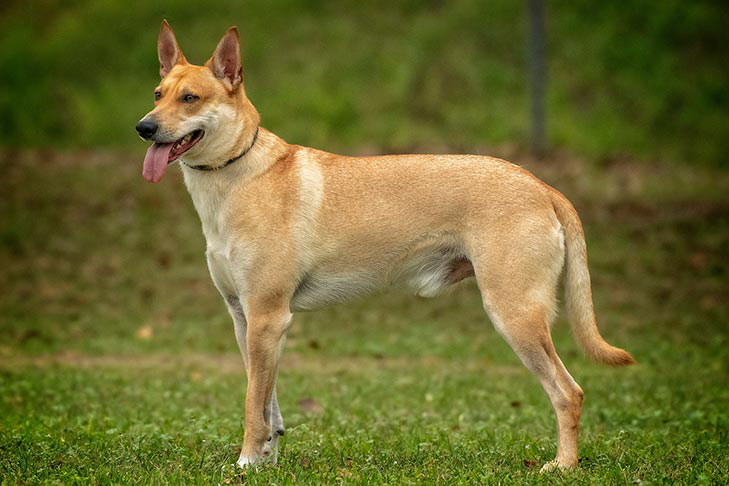

In [34]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [35]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [36]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [37]:
type(response2[0][0])

float

In [38]:
response2[0]

[0.17870040237903595,
 0.13383135199546814,
 -0.09375334531068802,
 0.2592350244522095,
 0.47878167033195496,
 0.24253161251544952,
 -0.012547305785119534,
 0.025524454191327095,
 -0.3065299987792969,
 -0.05006171390414238,
 0.4960617423057556,
 0.2937588095664978,
 -0.10482137650251389,
 0.20727938413619995,
 0.5738649964332581,
 0.11281649023294449,
 0.3919632136821747,
 0.006053171586245298,
 0.10420925915241241,
 0.14569886028766632,
 0.38699135184288025,
 0.03818243369460106,
 0.010774191468954086,
 0.24934278428554535,
 -0.14387431740760803,
 -0.16589699685573578,
 0.17532989382743835,
 -0.3856702148914337,
 0.4190075695514679,
 -0.016984570771455765,
 0.2693136930465698,
 0.21761853992938995,
 -0.0067712995223701,
 0.12360124289989471,
 0.008986278437077999,
 0.34518298506736755,
 0.10455890744924545,
 0.19960807263851166,
 0.3352145552635193,
 0.1075577437877655,
 0.31086888909339905,
 0.11815930902957916,
 0.0688147023320198,
 0.15545524656772614,
 0.21596749126911163,
 0.2391

In [39]:
import torch
import numpy as np
np.argmax(response, 1)

array([14])